#### 3D Unet using tranfer learning of VGG16 on first sythetic data

In [1]:
# check the status of GPU
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']


2022-04-28 16:45:59.289988: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 31596363136
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8121928971473665799
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0"



2022-04-28 16:46:00.679106: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-28 16:46:00.680760: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-28 16:46:00.740366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-04-28 16:46:00.740399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-28 16:46:00.743179: I tensorflow/stream_executor/pl

[None]

In [2]:
# !pip install classification-models-3D
# !pip install efficientnet-3D

In [3]:
DOCUMENT = True

In [4]:
# neptune document

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

if DOCUMENT:

    run = neptune.init(
        project="leeleeroy/UNet-3D-EM",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
        name = "UNet3D_64_vgg16",
    ) # necessary credentials, the name could be used to reproduce the results 

    # for callbacks in training



    neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
    
    # neptune document the hyper param.

    PARAMS = {'patchify': 64,
              "optimizer": {"learning_rate": 0.001, "beta_1":0.9,"optimizer": "Adam"},
              'epochs':100,
              'batch_size':8}

    # log hyper-parameters
    run['hyper-parameters'] = PARAMS
    run["sys/tags"].add(["3D_64","transfer", "vgg16", "val", "test", "100"])


https://app.neptune.ai/leeleeroy/UNet-3D-EM/e/UN1-5
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/home/li52/.conda/envs/seg/lib/python3.7/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")
/home/li52/.conda/envs/seg/lib/python3.7/site-packages/neptune/new/internal/utils/git.py:35: UserWarning: GitPython could not be initialized
  warnings.warn("GitPython could not be initialized")


#### read in the raw data

In [5]:
import os
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import os
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as k
import segmentation_models_3D as sm
from tensorflow.keras.utils import to_categorical

from skimage import io
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
# import keras

Using TensorFlow backend.


Segmentation Models: using `tf.keras` framework.


In [6]:
def readMRC(path):
    with mrcfile.open(path, mode='r+', permissive=True) as mrc:
        mrc.header.map = mrcfile.constants.MAP_ID # for synthetic data, need to generate ID
        data = mrc.data
    return data

# DATA_PATH = 'F:/MDC/4.1dataAugNeat/EM/3dem/data/interim/synthetic/'
DATA_PATH = './synthetic/'  # in hemera, only use relative path
data_ids = next(os.walk(DATA_PATH))[1]
raw = []
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):  
    path = DATA_PATH + id_
    datanames = os.listdir(path)
    for dataname in datanames:
        if os.path.splitext(dataname)[1] == '.mrc': # all .mrc under the path
            temp = readMRC(path + "/" + dataname).astype(np.uint8)
            raw.append(temp)
            print(dataname)
            
focal = raw[0:3]
GT = raw[3:len(raw)]
del raw, temp, datanames, dataname, path, data_ids, n, id_

  0%|          | 0/3 [00:00<?, ?it/s]

tomo2_focalseries.mrc
tomo3_focalseries.mrc
tomo1_focalseries.mrc


/home/li52/.conda/envs/seg/lib/python3.7/site-packages/mrcfile/mrcinterpreter.py:219: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


tomo2_groundtruth.mrc
tomo3_groundtruth.mrc


100%|██████████| 3/3 [00:00<00:00, 12.12it/s]

tomo1_groundtruth.mrc


In [7]:
# sanity check for the data type

# test = focal[0]
# print(test.dtype, test.shape)
# test1 = test[0,...]
# print(test1)


In [8]:
# raw data sorting: padding, reshape

import torchio as tio
from patchify import patchify, unpatchify

# training dataset raw
train_raw = np.vstack(([focal[0], focal[1]]));train = train_raw[...,np.newaxis].transpose((3,1,2,0)); label = np.vstack(([GT[0], GT[1]]))#;label = train_label[...,np.newaxis]

trainIO = tio.ScalarImage(tensor=train)
target_shape = 256,256,512  # padding into the same size
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(trainIO) # padding with mean
train_padd = resized.numpy().transpose((3,1,2,0)); train_padd = train_padd[...,0]
print(train_padd.shape);print(label.shape)

# testing dataset raw
X_test = focal[2]; X_test = X_test[...,np.newaxis].transpose((3,1,2,0))
Y_test_label = GT[2]
# Y_test_label = (Y_test_label > 0.5).astype(np.float) # 这里不要做二元化，下面再做二元化

testIO = tio.ScalarImage(tensor=X_test)
target_shape = 256,256,256
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(testIO)
test_padd = resized.numpy().transpose((3,1,2,0)); test_padd = test_padd[...,0];

testStackSize = test_padd.shape  # document the original size of image stack

/home/li52/.conda/envs/seg/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(512, 256, 256)
(512, 256, 256)


In [9]:
# print(X_test.dtype, X_test.shape)

In [10]:
# pre-processing the data: scaling, binarize 

X_train = train_padd; Y_train = label

X_test_raw = test_padd; Y_test_raw = Y_test_label

# binary the mask here
# X_train = (X_train / 255.).astype(np.float)  # 不需要scale，之后的会在进行scale
Y_train = ((Y_train / 255) > 0.5).astype(np.float)

# X_test = (X_test / 255.).astype(np.float)
Y_test = ((Y_test_raw / 255) > 0.5).astype(np.float)

print(X_train.dtype, Y_train.dtype)

# patchify the training data
img_patches = patchify(X_train, (64, 64, 64), step=64)  #Step=64 for 64 patches means no overlap
mask_patches = patchify(Y_train, (64, 64, 64), step=64)  
unpatchParaTrain = img_patches.shape

# patchify the test data
test_img_patches = patchify(X_test_raw, (64, 64, 64), step=64) 
test_mask_patches = patchify(Y_test_raw, (64, 64, 64), step=64) 
unpatchParaTest = test_img_patches.shape

print(test_mask_patches.shape, test_img_patches.shape)
# print(X_test_raw.shape)

uint8 float64
(4, 4, 4, 64, 64, 64) (4, 4, 4, 64, 64, 64)


/home/li52/.conda/envs/seg/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
/home/li52/.conda/envs/seg/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


In [11]:
# sanity check for the data type

print(X_test.dtype, Y_test.dtype)

uint8 float64


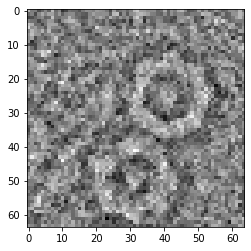

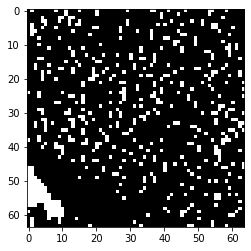

In [12]:
# sanity check

plt.imshow(img_patches[1,2,3,32,:,:], cmap='gray')  # 注意交换过次序，第一维表示图片
plt.figure();plt.imshow(mask_patches[1,2,3,32,:,:], cmap='gray')

In [13]:
# flatten the patches

input_img = np.reshape(img_patches, (-1, unpatchParaTrain[3], unpatchParaTrain[4], unpatchParaTrain[5]))
input_mask = np.reshape(mask_patches, (-1, unpatchParaTrain[3], unpatchParaTrain[4], unpatchParaTrain[5]))

X_test = np.reshape(test_img_patches, (-1, unpatchParaTest[3], unpatchParaTest[4], unpatchParaTest[5]))
Y_test = np.reshape(test_mask_patches, (-1, unpatchParaTest[3], unpatchParaTest[4], unpatchParaTest[5]))

print(X_test.shape)  # n_patches, x, y, z
print(Y_test.shape)

(64, 64, 64, 64)
(64, 64, 64, 64)


(64, 64, 64) uint8
[[125 147  90 ... 131 117  98]
 [148 141 129 ... 142 147 109]
 [158 109 104 ... 147 127 130]
 ...
 [148 129  99 ... 131 128 127]
 [117 150 153 ... 133 118 106]
 [144 132 106 ... 115 108  92]]


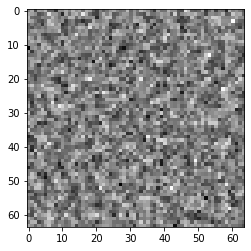

In [14]:
# sanity check the order

test1 = X_test[0,...]
print(test1.shape, test1.dtype)
plt.imshow(test1[0,...], cmap='gray')
print(test1[0,...])

In [15]:
# preprocessing the img into RGB 3 channel
n_classes = 2   # many classes by the final segmentation # 需要二元化mask才能做分类

train_img = np.stack((input_img,)*3, axis=-1)
train_mask = np.expand_dims(input_mask, axis=4) # expand one version
print('train img:', train_img.shape, 'train mask:', train_mask.shape)

# pre-processing for the test image

X_test = np.stack((X_test,)*3, axis=-1)
Y_test = np.expand_dims(Y_test, axis=4) # expand one version
print('test img:', X_test.shape, 'test mask:', Y_test.shape)

train img: (128, 64, 64, 64, 3) train mask: (128, 64, 64, 64, 1)
test img: (64, 64, 64, 64, 3) test mask: (64, 64, 64, 64, 1)


In [16]:
# sanity check for the binary of training mask

test = train_mask[0,...]
print(test[0,:,:,0])
# print(X_test[0,0,...])  # still 0-1

[[0. 1. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
# pre-processing the data into categories

train_mask_cat = to_categorical(train_mask, num_classes=n_classes) # trun into the sorts. transform last dimension into 2

X_train, X_val, Y_train, Y_val = train_test_split(train_img, train_mask_cat, test_size = 0.25, random_state = 0) # Slitting into validation sets

In [18]:
print(X_train.shape) #[0,0,...]
# print(X_train[0,0,...])  # 此时的状态是正确的
print('before pre:', np.min(X_train), np.max(X_train))

(96, 64, 64, 64, 3)
before pre: 0 255


In [19]:
# define the loss

# careful with the focal loss
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)  # 损失函数

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [20]:
# hyper param of the models

encoder_weights = 'imagenet'
BACKBONE = 'vgg16'  # other available models: vgg16, efficientnetb7, inceptionv3, resnet50
AKTIV = 'softmax'  
patch_size = 64
n_classes = 2
channels=3

LR = 0.0001
optim = k.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.5, 0.5])) # weights for segmentation classes
focal_loss = sm.losses.CategoricalFocalLoss()  # handiling the inbalance dataset
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]  

In [21]:
# define the callback 

# setting checkpoints
checkpointer = k.callbacks.ModelCheckpoint('./transfer3D/model/3d_unet_transfer.h5', verbose=1, save_best_only=True)

if DOCUMENT:
    callbacks = [
        #k.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
        neptune_cbk, 
        k.callbacks.TensorBoard(log_dir = './transfer3D/tensorBoard')  # save in new folder in hemera. Also update in neptune
    ]
else:
    callbacks = [
        #k.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
        k.callbacks.TensorBoard(log_dir = './transfer3D/tensorBoard')  # save in new folder in hemera. Also update in neptune
    ]

2022-04-28 16:46:07.527313: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-28 16:46:07.527345: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-28 16:46:07.527390: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2022-04-28 16:46:07.528733: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2022-04-28 16:46:07.629132: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2022-04-28 16:46:07.629397: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [22]:
# preprocess the training data

preprocess_input = sm.get_preprocessing(BACKBONE)
X_train_prep = preprocess_input(X_train)  # scale the dataset
X_val_prep = preprocess_input(X_val)

print(X_train_prep.shape, X_val_prep.shape, Y_train.shape)

testImg = X_train_prep[0,...]; testMask = Y_train[0,...]
print(testImg.shape)
print(np.min(testImg[0,...]))  # 这之后数值rescale了
print('before pre:', np.min(X_train), np.max(X_train))
print('after pre:', np.min(X_train_prep), np.max(X_train_prep))

(96, 64, 64, 64, 3) (32, 64, 64, 64, 3) (96, 64, 64, 64, 2)
(64, 64, 64, 3)
-123.68
before pre: 0 255
after pre: -123.68 151.061


In [23]:
# define the model

model = sm.Unet(BACKBONE, classes=n_classes, 
                input_shape=(patch_size, patch_size, patch_size, channels), # 64，64，64，3
                encoder_weights=encoder_weights,  # encoder initialized with imagenet
                activation=AKTIV)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

2022-04-28 16:46:08.242434: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-28 16:46:08.243082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-04-28 16:46:08.243117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-28 16:46:08.243148: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-28 16:46:08.243159: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-04-28 16:46:08.243171: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 64,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv3D)           (None, 64, 64, 64, 6 5248        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv3D)           (None, 64, 64, 64, 6 110656      block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling3D)      (None, 32, 32, 32, 6 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [ ]:
# train 

history=model.fit(X_train_prep, 
          Y_train,
          batch_size=8, 
          epochs=100,
          verbose=1,
          validation_data=(X_val_prep, Y_val),
         callbacks=callbacks)

2022-04-28 16:46:09.784106: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-28 16:46:09.784749: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/100


2022-04-28 16:46:13.681641: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-04-28 16:46:14.766796: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.0.176, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2022-04-28 16:46:14.863582: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


 1/12 [=>............................] - ETA: 1:28 - loss: 0.8612 - iou_score: 0.2097 - f1-score: 0.3411

2022-04-28 16:46:17.942648: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-28 16:46:17.942695: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-28 16:46:17.943959: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


 2/12 [====>.........................] - ETA: 7s - loss: 0.8594 - iou_score: 0.2115 - f1-score: 0.3430  

2022-04-28 16:46:18.572772: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-28 16:46:18.588169: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-28 16:46:18.594582: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-28 16:46:18.598095: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./transfer3D/tensorBoard/train/plugins/profile/2022_04_28_16_46_18
2022-04-28 16:46:18.599425: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./transfer3D/tensorBoard/train/plugins/profile/2022_04_28_16_46_18/gv017.cluster.trace.json.gz
2022-04-28 16:46:18.635065: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./transfer3D/tensorBoard/train/plugins/profile/2022_04_28_16_46_18
2022-04-28 16:46:18.643722: I te

12/12 [==============================] - 17s 818ms/step - loss: 0.8416 - iou_score: 0.2502 - f1-score: 0.3813 - val_loss: 0.8548 - val_iou_score: 0.4292 - val_f1-score: 0.4914
Epoch 2/100
12/12 [==============================] - 8s 703ms/step - loss: 0.7937 - iou_score: 0.4126 - f1-score: 0.4971 - val_loss: 0.8684 - val_iou_score: 0.4308 - val_f1-score: 0.4819
Epoch 3/100
12/12 [==============================] - 8s 702ms/step - loss: 0.7781 - iou_score: 0.4306 - f1-score: 0.4792 - val_loss: 0.8546 - val_iou_score: 0.4300 - val_f1-score: 0.4863
Epoch 4/100
12/12 [==============================] - 8s 706ms/step - loss: 0.7741 - iou_score: 0.4315 - f1-score: 0.4747 - val_loss: 0.8490 - val_iou_score: 0.3977 - val_f1-score: 0.4953
Epoch 5/100
12/12 [==============================] - 8s 704ms/step - loss: 0.7728 - iou_score: 0.4302 - f1-score: 0.4658 - val_loss: 0.8226 - val_iou_score: 0.4308 - val_f1-score: 0.4806
Epoch 6/100
12/12 [==============================] - 8s 705ms/step - loss: 0

In [ ]:
# save the model

model.save('./3DUnet/model/3D_model_vgg16_10epochs.h5')

In [ ]:
# visualize the loss and IOU loss

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show() # Save model

#### Test part

In [ ]:
# load the model

from keras.models import load_model
# from keras.models import load_model
my_model = load_model('./3DUnet/model/3D_model_vgg16_10epochs.h5', compile=False)

In [ ]:
# preprocess the test data

X_test_prep = preprocess_input(X_test) 

print('before pre:', np.min(X_test), np.max(X_test))
print('after pre:', np.min(X_test_prep), np.max(X_test_prep))

In [ ]:
# test on the test set

Y_pred = my_model.predict(X_test_prep)

Y_pred = np.asarray(Y_pred)
Y_pred_argmax = np.argmax(Y_pred, axis=4) 
Y_test_argmax = np.argmax(Y_test, axis=4)

In [ ]:
# sanity check for the data shape

print(Y_pred_argmax.shape)
print(Y_test_argmax.shape)
print(np.unique(Y_pred_argmax))

In [ ]:
# test in rando
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = Y_test[test_img_number]
ground_truth = np.squeeze(ground_truth)

test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)

test_pred1 = my_model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]
print('pred size:', test_prediction1.shape,' GT size:', ground_truth.shape, 'input size:', test_img.shape )
print(test_img.dtype)

In [ ]:
# test_img[0,:,:,0]

In [ ]:
# sanity check for the data matching

sliceNum = 10

plt.subplot(1,3,1)
plt.imshow(test_img[sliceNum,...]/255, cmap='gray')  # input
plt.subplot(1,3,2)
plt.imshow(ground_truth[sliceNum,...], cmap='gray')  # GT
plt.subplot(1,3,3)
plt.imshow(test_prediction1[sliceNum,...], cmap='gray') # pred

In [ ]:
# unpatchify back into the cubes

imagePatch = np.reshape(np.asarray(Y_pred_argmax),
                (unpatchParaTest[0], unpatchParaTest[1],unpatchParaTest[2],
                 unpatchParaTest[3], unpatchParaTest[4],unpatchParaTest[5]))
origTest = unpatchify(imagePatch, testStackSize)
print(origTest.shape)

In [ ]:
# sorting out the input, GT and prediction

# Y_test_raw needs to be binarized, then it can matched with prediction
Y_test_raw_bi = ((Y_test_raw/ 255) > 0.5).astype(np.float)

for i in range(origTest.shape[0]):
    
    predT = origTest[i,...] 
    focalT = X_test_raw[i,...] / 255
    truthT = Y_test_raw_bi[i,...] 

    bar = np.ones((predT.shape[0], 15))   # lines
    combTemp = np.concatenate((focalT, bar, predT, bar, truthT), axis=1)

    if DOCUMENT:
        # upload the test results into neptune with handle 'description'
        run["test/sample_images"].log(neptune.types.File.as_image(combTemp), name=str(i), description='test images from 3rd stack')  
    


In [ ]:
# stop the neptune
if DOCUMENT:
    run.stop() 

#### Check the generated results locally

In [ ]:
# sanity check for the results

tempIMG = origTest[0,:,:]

plt.imshow(tempIMG, cmap='gray')

In [ ]:
# visualize the three dataset together

NUM = 0
predT = origTest[NUM,...] #* 255
plt.figure()
plt.imshow(predT, cmap='gray')
focalT = X_test_raw[NUM,...]/255
truthT = Y_test_raw_bi[NUM,...] #* 255

bar = np.ones((predT.shape[0], 15)) #* 255  # lines
combTemp = np.concatenate((focalT, bar, predT, bar, truthT), axis=1)
plt.imshow(combTemp, cmap='gray')


# print(X_test_raw.shape, Y_test_raw_bi.shape)

In [ ]:
# !pip install "napari[all]"

In [ ]:
# veiw the 3D volume 
# not working on the hemera

# from skimage import data
# import napari

# viewer = napari.view_image(data.cells3d(), channel_axis=1, ndisplay=3)

# viewer = napari.view_image(original, channel_axis=1, ndisplay=3)